In [5]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
import mlflow
import mlflow.tensorflow
import tensorflow as tf
from tensorflow.data import AUTOTUNE
import dagshub
import mlflow
from mlflow.models import infer_signature

In [6]:
!unzip "/content/drive/MyDrive/pruebas_tareasICD/dataset_final.zip" -d "/content/data"

Archive:  /content/drive/MyDrive/pruebas_tareasICD/dataset_final.zip
   creating: /content/data/dataset_final/test/
   creating: /content/data/dataset_final/test/glioma_tumor/
  inflating: /content/data/dataset_final/test/glioma_tumor/G_12.jpg  
  inflating: /content/data/dataset_final/test/glioma_tumor/G_126.jpg  
  inflating: /content/data/dataset_final/test/glioma_tumor/G_134.jpg  
  inflating: /content/data/dataset_final/test/glioma_tumor/G_139.jpg  
  inflating: /content/data/dataset_final/test/glioma_tumor/G_143.jpg  
  inflating: /content/data/dataset_final/test/glioma_tumor/G_153.jpg  
  inflating: /content/data/dataset_final/test/glioma_tumor/G_156.jpg  
  inflating: /content/data/dataset_final/test/glioma_tumor/G_16.jpg  
  inflating: /content/data/dataset_final/test/glioma_tumor/G_162.jpg  
  inflating: /content/data/dataset_final/test/glioma_tumor/G_168.jpg  
  inflating: /content/data/dataset_final/test/glioma_tumor/G_17.jpg  
  inflating: /content/data/dataset_final/test/

## Cargando los datos

In [7]:
# Directorio actual
directorio_actual_colab = '/content'

# Obtener la ruta del directorio 'train'
train_dir = os.path.join(directorio_actual_colab, 'data', 'dataset_final', 'train')
test_dir = os.path.join(directorio_actual_colab, 'data', 'dataset_final', 'test')
val_dir = os.path.join(directorio_actual_colab, 'data', 'dataset_final', 'val')

# Verificar que las rutas sean correctas
print("Directorio de entrenamiento:", train_dir)
print("Directorio de prueba:", test_dir)
print("Directorio de validación:", val_dir)

Directorio de entrenamiento: /content/data/dataset_final/train
Directorio de prueba: /content/data/dataset_final/test
Directorio de validación: /content/data/dataset_final/val


## Preparación de conjuntos de datos para entrenar, validar y probar los modelos

En esta parte se crean generadores de datos que aplican la normalización por rescale (dividiendo los valores de píxeles por 255) a las imágenes en cada conjunto. Además, especifica el tamaño del lote, el tamaño objetivo de las imágenes y el modo de clase 'sparse' para indicar que las etiquetas son enteros.

flow_from_directory utiliza el orden de las carpetas para asignar etiquetas a las clases. En este caso, las etiquetas asignadas para entrenar el modelo son las siguientes:

| Clase       | Valor |
|-------------|-------|
| glioma      | 0     |
| meningioma  | 1     |
| normal      | 2     |
| pituitaria  | 3     |






In [8]:
batch_size = 32
target_size = (224, 224)

# Generador de datos para dataset de entrenamiento
train_datagen = ImageDataGenerator(rescale=1./255.)
train_dataset = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='sparse')

# Generador de datos para dataset de validación
val_datagen = ImageDataGenerator(rescale=1./255.)
val_dataset = val_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='sparse')

# Generador de datos para dataset de prueba
test_datagen = ImageDataGenerator(rescale=1./255.)
test_dataset = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='sparse')

Found 2475 images belonging to 4 classes.
Found 309 images belonging to 4 classes.
Found 312 images belonging to 4 classes.


## Entrenamiento con MLflow

## VGG16

VGG16 es una arquitectura de red neuronal convolucional que ha demostrado un rendimiento sólido en tareas de visión por computadora, incluida la clasificación de imágenes. Fue desarrollada por el grupo Visual Geometry Group (VGG) y ha sido utilizada con éxito en diversos conjuntos de datos.

Utilizaremos este modelo preentrenado para ahorrar tiempo y recursos, ya que la red ya ha aprendido características útiles de un gran conjunto de datos (por ejemplo, ImageNet) y se puede transferir ese conocimiento a nuestra tarea.

In [11]:
import dagshub
import mlflow

dagshub.init("BrainTumors_CNN", "RicardoHdz12", mlflow=True)
mlflow.start_run()

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=093355b9-bd53-42ec-a1de-e4c802c074ce&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=f9db6eb762aedd300b37b187c2e994b5114646543a9895e60711b29603f9483f




Repository initialized!

<ActiveRun: >

In [14]:
experiment_name = "VGG16_modelo"
experiment_id = mlflow.create_experiment(experiment_name)


In [18]:
import mlflow
import mlflow.tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dropout, Dense

# Definir la arquitectura del modelo
base_model = tf.keras.applications.VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(4, activation=tf.nn.softmax))

# Resumen del modelo
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_1 (Dropout)         (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 4)                 100356    
                                                                 
Total params: 14815044 (56.51 MB)
Trainable params: 100356 (392.02 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [19]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [23]:
# Crear un experimento de MLflow

mlflow.tensorflow.autolog()
# Iniciar un experimento de MLflow
with mlflow.start_run(experiment_id=experiment_id, run_name=experiment_name):
    epochs = 15
    # Entrenar el modelo
    hist = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs)

    # Registrar métricas
    predictions = model.predict(test_dataset)
    signature = infer_signature(test_dataset[0][0], predictions)


    mlflow.sklearn.log_model(model, experiment_name, signature=signature)




2023/11/25 00:11:45 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.
2023/11/25 00:11:45 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.


Epoch 1/15
78/78 [==============================] - 28s 194ms/step - loss: 0.9378 - accuracy: 0.6259 - val_loss: 0.5227 - val_accuracy: 0.8026
Epoch 2/15
78/78 [==============================] - 11s 142ms/step - loss: 0.4700 - accuracy: 0.8214 - val_loss: 0.4112 - val_accuracy: 0.8511
Epoch 3/15
78/78 [==============================] - 12s 160ms/step - loss: 0.3545 - accuracy: 0.8655 - val_loss: 0.3454 - val_accuracy: 0.8608
Epoch 4/15
78/78 [==============================] - 12s 148ms/step - loss: 0.2761 - accuracy: 0.8978 - val_loss: 0.2939 - val_accuracy: 0.9094
Epoch 5/15
78/78 [==============================] - 13s 165ms/step - loss: 0.2131 - accuracy: 0.9180 - val_loss: 0.3063 - val_accuracy: 0.8900
Epoch 6/15
78/78 [==============================] - 13s 170ms/step - loss: 0.1786 - accuracy: 0.9345 - val_loss: 0.3591 - val_accuracy: 0.8867
Epoch 7/15
78/78 [==============================] - 12s 158ms/step - loss: 0.1350 - accuracy: 0.9568 - val_loss: 0.3519 - val_accuracy: 0.8835

2023/11/25 00:16:08 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: '>=' not supported between instances of 'slice' and 'int'
2023/11/25 00:16:08 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2023/11/25 00:16:21 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpsuqjqa0r/model, flavor: tensorflow), fall back to return ['tensorflow==2.14.0']. Set logging level to DEBUG to see the full traceback.


10/10 [==============================] - 4s 432ms/step


2023/11/25 00:16:46 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp0pckyvxg/model/model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.2.2', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback.


## Matriz de confusión

10/10 [==============================] - 1s 134ms/step


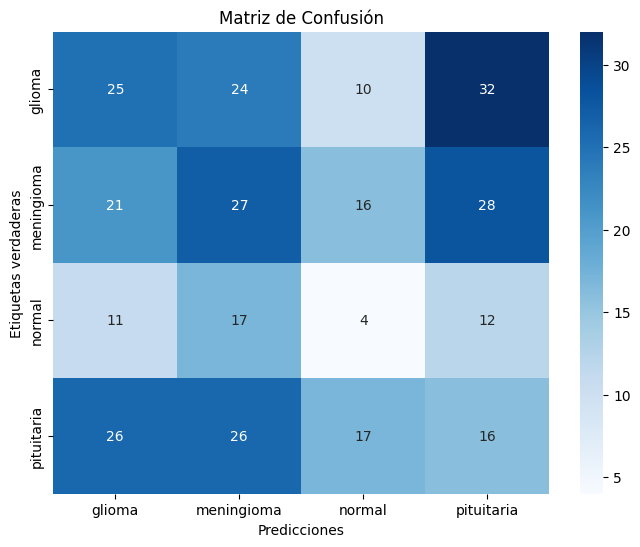

Classification Report:
               precision    recall  f1-score   support

      glioma       0.30      0.27      0.29        91
  meningioma       0.29      0.29      0.29        92
      normal       0.09      0.09      0.09        44
  pituitaria       0.18      0.19      0.18        85

    accuracy                           0.23       312
   macro avg       0.21      0.21      0.21       312
weighted avg       0.23      0.23      0.23       312



In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

class_dict = {'glioma': 0, 'meningioma': 1, 'normal': 2, 'pituitaria': 3}

# Obtener las predicciones para el conjunto de prueba
predictions = model.predict(test_dataset)

# Transformar las etiquetas de one-hot a enteros (asumiendo sparse_categorical_crossentropy)
y_true_indices = test_dataset.classes

# Crear un diccionario inverso para mapear índices a etiquetas de clases
inverse_class_dict = {v: k for k, v in class_dict.items()}

# Obtener las etiquetas reales de las clases
y_true = [inverse_class_dict[index] for index in y_true_indices]

# Obtener las clases predichas por el modelo
y_pred_indices = np.argmax(predictions, axis=1)
y_pred = [inverse_class_dict[index] for index in y_pred_indices]

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

# Etiquetas de las clases (cambia esto según tus clases)
class_labels = list(class_dict.keys())

# Crear un objeto de matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas verdaderas')
plt.title('Matriz de Confusión')
plt.show()

# Imprimir el classification_report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_labels))



## Observaciones

* El modelo muestra un accuracy de 0.89 en el conjunto de validación, sin embargo, hay variaciones en la precisión, recall y F1-score entre las clases. Por ejemplo, para la clase "normal", la precisión, recall y F1-score son particularmente bajos, lo que indica que el modelo tiene dificultades para clasificar correctamente instancias de esta clase.


* El rendimiento general del modelo parece ser bajo, con métricas modestas en precisión, recuperación y F1-score. Esto sugiere que el modelo puede necesitar ajustes, como cambios en la arquitectura del modelo, la estrategia de entrenamiento, o la cantidad de datos utilizados.

Vamos a modificar la arquitecura de este modelo atendiendo el punto anterior.

## VGG V2

Este modelo será una modificacion del modelo anterior, donde se agregan más capas

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

# Definir la arquitectura del modelo
base_model = tf.keras.applications.VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

vgg_v2 = Sequential()
vgg_v2.add(base_model)

# Añadir más capas convolucionales y de agrupación con tamaños de filtro y pasos ajustados
vgg_v2.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
vgg_v2.add(MaxPooling2D((2, 2)))
vgg_v2.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
vgg_v2.add(MaxPooling2D((2, 2)))

vgg_v2.add(Flatten())
vgg_v2.add(Dropout(0.5))

# Añadir más capas densas
vgg_v2.add(Dense(256, activation='relu'))
vgg_v2.add(Dropout(0.5))
vgg_v2.add(Dense(128, activation='relu'))

vgg_v2.add(Dense(4, activation='softmax'))

# Resumen del modelo
vgg_v2.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 128)         589952    
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 3, 3, 128)         0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 3, 3, 64)          73792     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 1, 1, 64)          0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 64)               

In [30]:
experiment_name = "VGGv2"
experiment_id = mlflow.create_experiment(experiment_name)

In [32]:
vgg_v2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

mlflow.tensorflow.autolog()
# Iniciar un experimento de MLflow
with mlflow.start_run(experiment_id=experiment_id, run_name=experiment_name):
    epochs = 20
    # Entrenar el modelo
    hist = vgg_v2.fit(train_dataset, validation_data=val_dataset, epochs=epochs)

    # Registrar métricas
    predictions = vgg_v2.predict(test_dataset)
    signature = infer_signature(test_dataset[0][0], predictions)


    mlflow.tensorflow.log_model(vgg_v2, experiment_name, signature=signature)



2023/11/25 00:24:51 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.
2023/11/25 00:24:51 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.


Epoch 1/20
78/78 [==============================] - 17s 163ms/step - loss: 1.2845 - accuracy: 0.3531 - val_loss: 0.9378 - val_accuracy: 0.5955
Epoch 2/20
78/78 [==============================] - 13s 162ms/step - loss: 0.9423 - accuracy: 0.5798 - val_loss: 0.6343 - val_accuracy: 0.8091
Epoch 3/20
78/78 [==============================] - 14s 176ms/step - loss: 0.7315 - accuracy: 0.6937 - val_loss: 0.4773 - val_accuracy: 0.8350
Epoch 4/20
78/78 [==============================] - 13s 170ms/step - loss: 0.5762 - accuracy: 0.7782 - val_loss: 0.3938 - val_accuracy: 0.8544
Epoch 5/20
78/78 [==============================] - 12s 151ms/step - loss: 0.4836 - accuracy: 0.8149 - val_loss: 0.4474 - val_accuracy: 0.8091
Epoch 6/20
78/78 [==============================] - 12s 155ms/step - loss: 0.3926 - accuracy: 0.8545 - val_loss: 0.3910 - val_accuracy: 0.8447
Epoch 7/20
78/78 [==============================] - 14s 170ms/step - loss: 0.3336 - accuracy: 0.8715 - val_loss: 0.2965 - val_accuracy: 0.8900

2023/11/25 00:29:45 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: '>=' not supported between instances of 'slice' and 'int'
2023/11/25 00:29:45 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


10/10 [==============================] - 2s 152ms/step


10/10 [==============================] - 1s 132ms/step


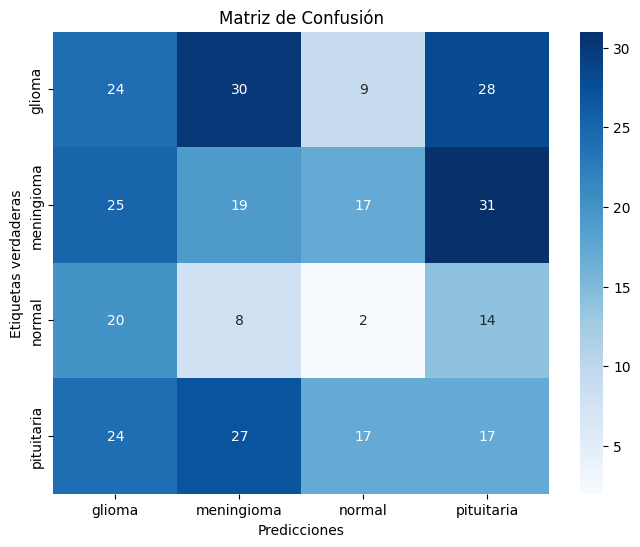

Classification Report:
               precision    recall  f1-score   support

      glioma       0.26      0.26      0.26        91
  meningioma       0.23      0.21      0.22        92
      normal       0.04      0.05      0.04        44
  pituitaria       0.19      0.20      0.19        85

    accuracy                           0.20       312
   macro avg       0.18      0.18      0.18       312
weighted avg       0.20      0.20      0.20       312



In [33]:
class_dict = {'glioma': 0, 'meningioma': 1, 'normal': 2, 'pituitaria': 3}

# Obtener las predicciones para el conjunto de prueba
predictions = vgg_v2.predict(test_dataset)

# Transformar las etiquetas de one-hot a enteros (asumiendo sparse_categorical_crossentropy)
y_true_indices = test_dataset.classes

# Crear un diccionario inverso para mapear índices a etiquetas de clases
inverse_class_dict = {v: k for k, v in class_dict.items()}

# Obtener las etiquetas reales de las clases
y_true = [inverse_class_dict[index] for index in y_true_indices]

# Obtener las clases predichas por el modelo
y_pred_indices = np.argmax(predictions, axis=1)
y_pred = [inverse_class_dict[index] for index in y_pred_indices]

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

# Etiquetas de las clases (cambia esto según tus clases)
class_labels = list(class_dict.keys())

# Crear un objeto de matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas verdaderas')
plt.title('Matriz de Confusión')
plt.show()

# Imprimir el classification_report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_labels))


## Observaciones

Este modelo mejora el accuracy en el conjunto de validación, anteriormente se logró un accuracy de 0.89 y el modelo VGG v2 alcanzó 0.92

Nuevamente, en métricas más robustas muestra un desempeño bajo

## Modelo 2 *ResNet50*

In [34]:
experiment_name = "ResNet50_Model"
experiment_id = mlflow.create_experiment(experiment_name)


In [35]:
res_net_model =tf.keras.applications.resnet.ResNet50(include_top=False)
res_net_model.trainable = False


# Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224,3), name="input_layer")
x = res_net_model(inputs)




# Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)



x=tf.keras.layers.Flatten()(x)
x=tf.keras.layers.Dense(512, activation="relu")(x)
x=tf.keras.layers.Dropout(0.5)(x)

outputs=tf.keras.layers.Dense(4, activation="softmax",name="output_layer")(x)

model2= tf.keras.Model(inputs, outputs)

model2.summary()

94765736/94765736 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048   23587712  
                             )                                   
                                                                 
 global_average_pooling_lay  (None, 2048)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 512)               1049088

In [36]:


# Compile the model
model2.compile(loss='sparse_categorical_crossentropy', # different loss function for multiclass classifcation
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=["accuracy"]
             )


In [39]:
mlflow.tensorflow.autolog()
with mlflow.start_run(experiment_id=experiment_id, run_name=experiment_name):
    epochs = 50
    # Entrenar el modelo
    history2= model2.fit(train_dataset, epochs=epochs, validation_data= val_dataset)
    # Registrar métricas
    predictions = model2.predict(test_dataset)
    signature = infer_signature(test_dataset[0][0], predictions)


    mlflow.tensorflow.log_model(model2, experiment_name, signature=signature)


2023/11/25 00:42:18 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.
2023/11/25 00:42:18 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.


Epoch 1/50
78/78 [==============================] - 11s 133ms/step - loss: 1.0894 - accuracy: 0.5046 - val_loss: 1.0446 - val_accuracy: 0.6019
Epoch 2/50
78/78 [==============================] - 10s 132ms/step - loss: 1.0927 - accuracy: 0.4962 - val_loss: 1.0204 - val_accuracy: 0.5696
Epoch 3/50
78/78 [==============================] - 10s 132ms/step - loss: 1.0839 - accuracy: 0.5095 - val_loss: 1.0170 - val_accuracy: 0.5502
Epoch 4/50
78/78 [==============================] - 10s 133ms/step - loss: 1.0678 - accuracy: 0.5261 - val_loss: 1.0036 - val_accuracy: 0.5663
Epoch 5/50
78/78 [==============================] - 10s 129ms/step - loss: 1.0598 - accuracy: 0.5366 - val_loss: 0.9890 - val_accuracy: 0.5922
Epoch 6/50
78/78 [==============================] - 10s 129ms/step - loss: 1.0697 - accuracy: 0.5160 - val_loss: 0.9944 - val_accuracy: 0.5825
Epoch 7/50
78/78 [==============================] - 10s 131ms/step - loss: 1.0724 - accuracy: 0.5107 - val_loss: 0.9937 - val_accuracy: 0.5599

2023/11/25 00:52:51 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: '>=' not supported between instances of 'slice' and 'int'
2023/11/25 00:52:51 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


10/10 [==============================] - 1s 115ms/step


10/10 [==============================] - 1s 108ms/step


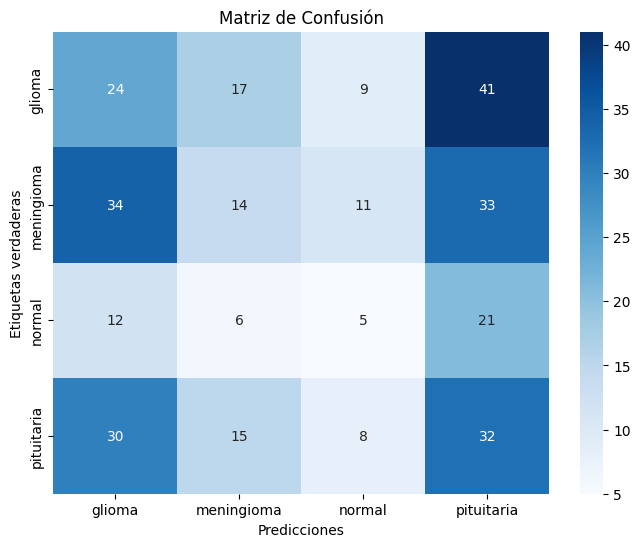

Classification Report:
               precision    recall  f1-score   support

      glioma       0.24      0.26      0.25        91
  meningioma       0.27      0.15      0.19        92
      normal       0.15      0.11      0.13        44
  pituitaria       0.25      0.38      0.30        85

    accuracy                           0.24       312
   macro avg       0.23      0.23      0.22       312
weighted avg       0.24      0.24      0.23       312



In [40]:
# Obtener las predicciones para el conjunto de prueba
predictions = model2.predict(test_dataset)

# Transformar las etiquetas de one-hot a enteros (asumiendo sparse_categorical_crossentropy)
y_true_indices = test_dataset.classes

# Crear un diccionario inverso para mapear índices a etiquetas de clases
inverse_class_dict = {v: k for k, v in class_dict.items()}

# Obtener las etiquetas reales de las clases
y_true = [inverse_class_dict[index] for index in y_true_indices]

# Obtener las clases predichas por el modelo
y_pred_indices = np.argmax(predictions, axis=1)
y_pred = [inverse_class_dict[index] for index in y_pred_indices]

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

# Etiquetas de las clases (cambia esto según tus clases)
class_labels = list(class_dict.keys())

# Crear un objeto de matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas verdaderas')
plt.title('Matriz de Confusión')
plt.show()

# Imprimir el classification_report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_labels))

## InceptionV3

In [42]:
experiment_name = "InceptionV3_model"
experiment_id = mlflow.create_experiment(experiment_name)


In [43]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models

# Cargar el modelo InceptionV3 preentrenado sin la capa densa superior (include_top=False)
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

inception_model.trainable  = False
# Crear un modelo secuencial con el modelo base InceptionV3
model_inception = models.Sequential()
# Agregar el modelo InceptionV3 como una capa al modelo secuencial
model_inception.add(inception_model)

# Agregar capas adicionales al modelo
model_inception.add(layers.GlobalAveragePooling2D(name="global_average_pooling_layer"))
model_inception.add(layers.Flatten())
model_inception.add(layers.Dense(512, activation='relu'))
model_inception.add(layers.Dropout(0.5))
model_inception.add(layers.Dense(256, activation='relu'))
model_inception.add(layers.Dropout(0.3))
model_inception.add(layers.Dense(128, activation='relu'))
model_inception.add(layers.Dropout(0.3))
model_inception.add(layers.Dense(4, activation='softmax', name="output_layer"))

# Compilar el modelo
model_inception.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model_inception.summary()

87910968/87910968 [==============================] - 0s 0us/step
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling_lay  (None, 2048)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 flatten_5 (Flatten)         (None, 2048)              0         
                                                                 
 dense_9 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                       

In [44]:
mlflow.tensorflow.autolog()
with mlflow.start_run(experiment_id=experiment_id, run_name=experiment_name):
    epochs = 20
    # Entrenar el modelo
    history3= model_inception.fit(train_dataset, epochs=epochs, validation_data= val_dataset)
    # Registrar métricas
    predictions = model_inception.predict(test_dataset)
    signature = infer_signature(test_dataset[0][0], predictions)


    mlflow.tensorflow.log_model(model_inception, experiment_name, signature=signature)

2023/11/25 00:55:39 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.
2023/11/25 00:55:39 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.


Epoch 1/20
78/78 [==============================] - 19s 140ms/step - loss: 1.2661 - accuracy: 0.4521 - val_loss: 0.8929 - val_accuracy: 0.6084
Epoch 2/20
78/78 [==============================] - 7s 92ms/step - loss: 0.8827 - accuracy: 0.6360 - val_loss: 0.6595 - val_accuracy: 0.7735
Epoch 3/20
78/78 [==============================] - 8s 97ms/step - loss: 0.7381 - accuracy: 0.7046 - val_loss: 0.6029 - val_accuracy: 0.7573
Epoch 4/20
78/78 [==============================] - 8s 96ms/step - loss: 0.6672 - accuracy: 0.7418 - val_loss: 0.5811 - val_accuracy: 0.7573
Epoch 5/20
78/78 [==============================] - 7s 89ms/step - loss: 0.5994 - accuracy: 0.7640 - val_loss: 0.5510 - val_accuracy: 0.7832
Epoch 6/20
78/78 [==============================] - 9s 109ms/step - loss: 0.5778 - accuracy: 0.7806 - val_loss: 0.5514 - val_accuracy: 0.7832
Epoch 7/20
78/78 [==============================] - 7s 91ms/step - loss: 0.5602 - accuracy: 0.7705 - val_loss: 0.5459 - val_accuracy: 0.7864
Epoch 8/20

2023/11/25 00:58:47 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: '>=' not supported between instances of 'slice' and 'int'
2023/11/25 00:58:47 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


10/10 [==============================] - 3s 217ms/step


10/10 [==============================] - 1s 88ms/step


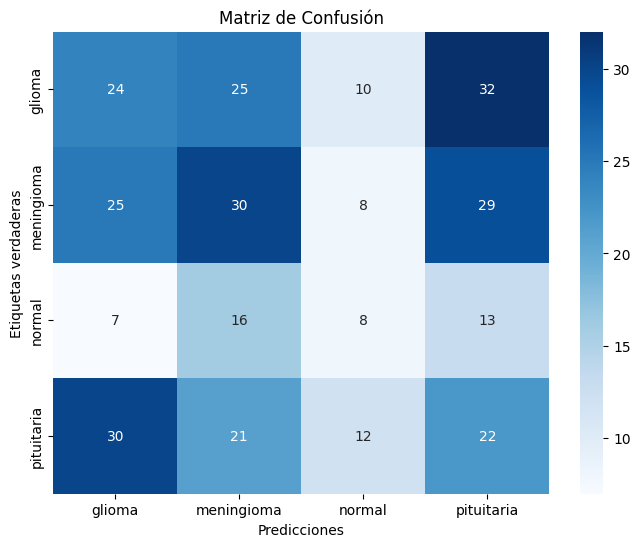

Classification Report:
               precision    recall  f1-score   support

      glioma       0.28      0.26      0.27        91
  meningioma       0.33      0.33      0.33        92
      normal       0.21      0.18      0.20        44
  pituitaria       0.23      0.26      0.24        85

    accuracy                           0.27       312
   macro avg       0.26      0.26      0.26       312
weighted avg       0.27      0.27      0.27       312



In [45]:
class_dict = {'glioma': 0, 'meningioma': 1, 'normal': 2, 'pituitaria': 3}
# Obtener las predicciones para el conjunto de prueba
predictions = model_inception.predict(test_dataset)
# Transformar las etiquetas de one-hot a enteros (asumiendo sparse_categorical_crossentropy)
y_true_indices = test_dataset.classes

# Crear un diccionario inverso para mapear índices a etiquetas de clases
inverse_class_dict = {v: k for k, v in class_dict.items()}

# Obtener las etiquetas reales de las clases
y_true = [inverse_class_dict[index] for index in y_true_indices]

# Obtener las clases predichas por el modelo
y_pred_indices = np.argmax(predictions, axis=1)
y_pred = [inverse_class_dict[index] for index in y_pred_indices]

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

# Etiquetas de las clases (cambia esto según tus clases)
class_labels = list(class_dict.keys())

# Crear un objeto de matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas verdaderas')
plt.title('Matriz de Confusión')
plt.show()

# Imprimir el classification_report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_labels))

## Selección del modelo

Se trabajará con el modelo `VGG V2` pues mostró un accuracy mayor a los demás en el conjunto de validación.


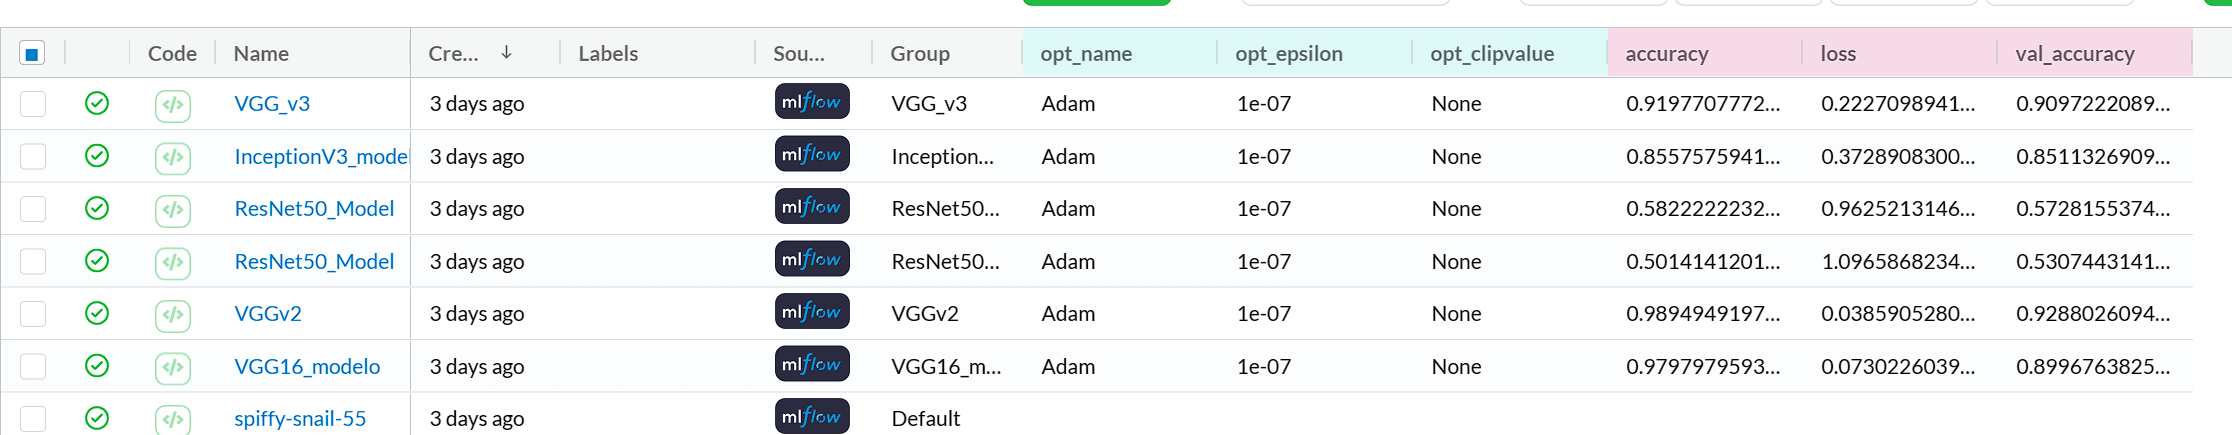



El accuracy puede no ser la mejor métrica para nuestra tarea. Las métricas robustas como precision, recall y f1-score proporcionan una visión más completa del rendimiento del modelo. Sin embargo, cabe destacar que la calidad de las imágenes puede ser un factor crítico en el rendimiento del modelo, especialmente en tareas de clasificación de tumores. Imágenes de baja calidad, ruido o variabilidad en las condiciones de captura pueden dificultar la tarea de clasificación.

Además, la generación de datos adicionales puede ser un desafío en este contexto, ya que se trata de imágenes de tumores, generar datos adicionales de manera efectiva implica replicar de manera precisa la variabilidad y la complejidad de las condiciones reales en las que se capturaron las imágenes originales. Esto puede ser difícil de lograr y puede introducir ruido si no se tiene un control preciso sobre las condiciones de generación de datos.